In [ ]:
# Exploratory Process, heavily annotated with my own notes
# Note: This is heavily annotated with my own notes as reminders to myself and just my through process along the way
# There is a separate clean version of the exploration using only relevant programming and notes

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure
import re

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

BASE_PATH_TO_FOLDER = input("Please provide the path to the root folder of this project: ")
CSV_KANGLE = BASE_PATH_TO_FOLDER + "/data/raw/Portland Crime Data Raw.csv"
CSV_PPB = BASE_PATH_TO_FOLDER + "/data/raw/CrimeData-2023.csv"

In [ ]:
df = pd.read_csv(CSV_KANGLE, sep='\t')

In [2]:
# Testing to ensure data is properly showing when using tab separator
df.head()

,Unnamed: 0,Address,CaseNumber,CrimeAgainst,Neighborhood,OccurDate,OccurTime,OffenseCategory,OffenseType,OpenDataLat,OpenDataLon,OpenDataX,OpenDataY,ReportDate,OffenseCount
0,131141,700 BLOCK OF SW KING AVE,24-933461,Property,Goose Hollow,2024-12-31,835,Larceny Offenses,All Other Larceny,45.522619,-122.695457,7639475.0,684279.0,2024-12-31,1
1,144335,2500 BLOCK OF NE MARTIN LUTHER KING JR BLVD,24-333349,Property,Eliot,2024-12-31,1815,Burglary,Burglary,45.540665,-122.661543,7648340.0,690622.0,2024-12-31,1
2,137002,1500 BLOCK OF N FLINT AVE,24-333656,Property,Lloyd,2024-12-31,1900,Larceny Offenses,Theft of Motor Vehicle Parts or Accessories,45.534075,-122.668690,7646445.0,688269.0,2024-12-31,1
3,124540,NaN,24-X6019097,Person,Sumner,2024-12-31,1740,Homicide Offenses,Murder and Non-negligent Manslaughter,NaN,NaN,NaN,NaN,2024-12-31,1
4,130216,600 BLOCK OF SW PARK AVE,24-933457,Property,Downtown,2024-12-31,1020,Larceny Offenses,Theft From Motor Vehicle,45.519952,-122.680464,7643290.0,683203.0,2024-12-31,1


In [3]:
df.to_csv('Portland Crime Data Raw commaseparated.csv', index=False)

In [4]:
# Checking if Unnamed: 0 column is a unique identifier
df['Unnamed: 0'].duplicated().any()
# Confirmed uniqueness of initial column, renaming to ID
df = df.rename(columns = {'Unnamed: 0': 'ID'})

In [98]:
# Getting an idea of where various values lie that might be worth investigating
# The total count for any crime by Neighborhood
df['Neighborhood'].value_counts()
# The total count of any crime by OffenseType
df['OffenseType'].value_counts()
# The total count of any crime by OffenseCategory
df['OffenseCategory'].value_counts()
# The frequency of any crime per day (based on ReportDate)
df['ReportDate'].value_counts()
# The frequency of any crime against
df['CrimeAgainst'].value_counts()
# The frequency of any crime against
df['OccurHour'].value_counts(sort=False)

OccurHour
8     21267
18    31546
19    28786
17    31989
10    22160
23    25242
21    28068
13    23742
12    32242
0     35246
15    26305
14    24444
6     12437
1     18555
9     20209
11    22165
5     11778
20    29207
4     12586
2     16212
16    27500
22    30437
7     15352
3     14412
Name: count, dtype: int64

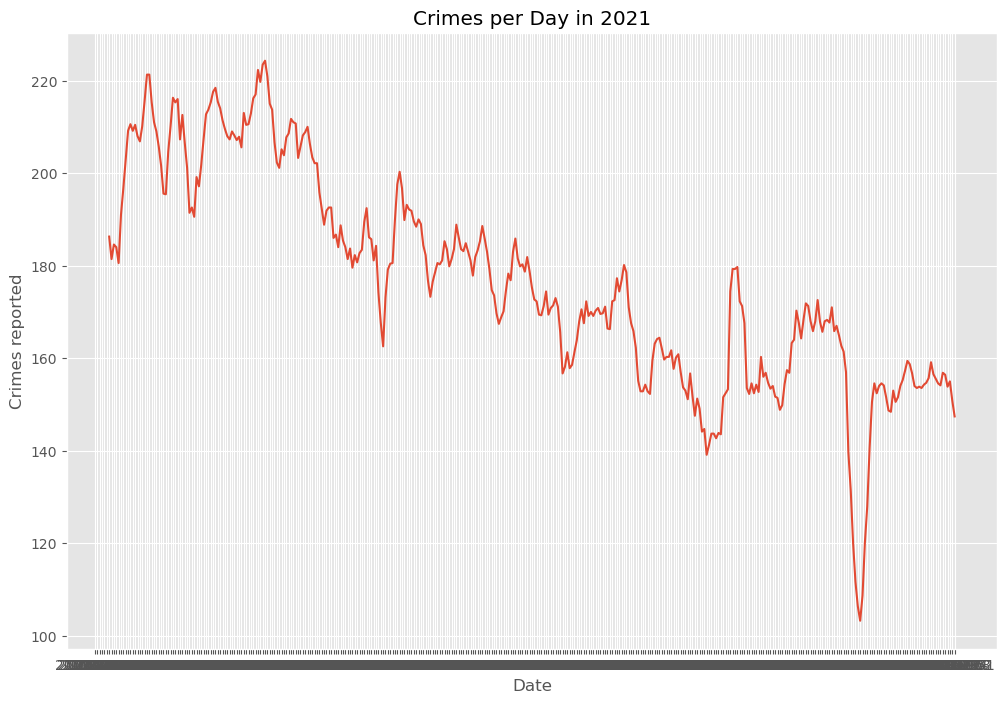

In [6]:
report_date_freqency = pd.to_datetime(df['ReportDate']).value_counts(sort=False)
report_date_freqency_2021 = df[pd.to_datetime(df['ReportDate']).dt.year == 2021]
report_date_freqency_2021 = report_date_freqency_2021['ReportDate'].value_counts(sort=False)
rolling_average = report_date_freqency_2021.rolling(window=7).mean()
# report_date_freqency_2021 = report_date_freqency_2021.value_counts(sort=False)
plt.plot(rolling_average.index, rolling_average.values)
plt.title('Crimes per Day in 2021')
plt.xlabel('Date')
plt.ylabel('Crimes reported')
plt.show()

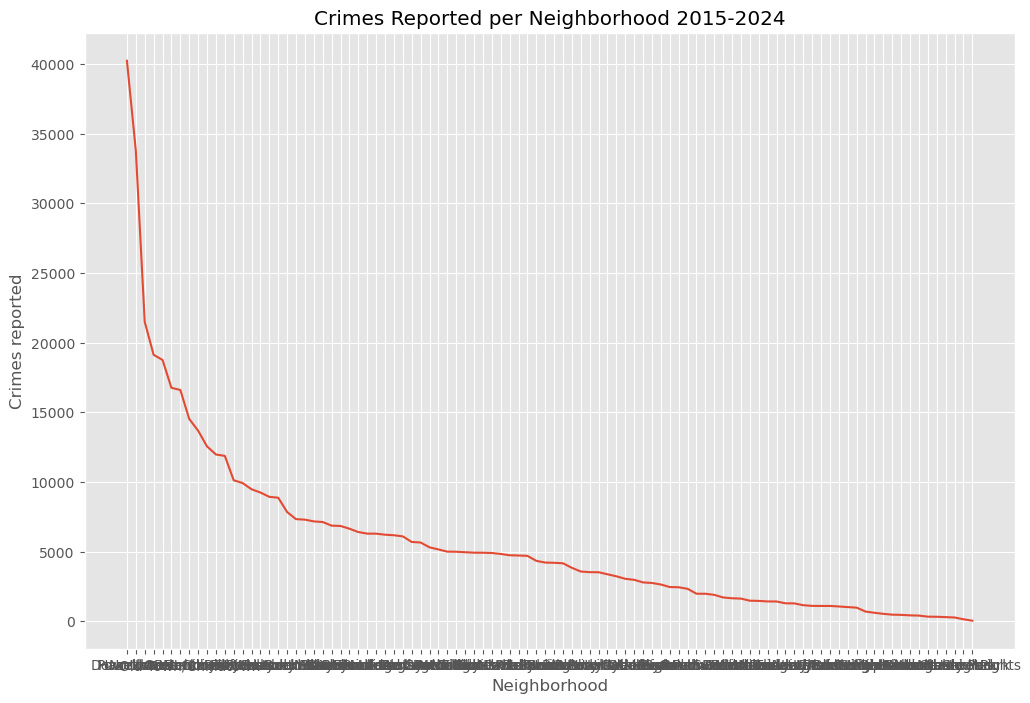

In [7]:
neighborhood_frequency = df['Neighborhood'].value_counts(sort=False)
plt.plot(neighborhood_frequency.index, neighborhood_frequency.values)
plt.title('Crimes Reported per Neighborhood 2015-2024')
plt.xlabel('Neighborhood')
plt.ylabel('Crimes reported')
plt.show()

In [8]:
pd.set_option('display.max_rows', None)
df['Neighborhood'].value_counts()
pd.set_option('display.max_rows', 10)

In [26]:
# At this point, I want to be able to view some of this data in Tableau as a map. Neighborhood names are not definted
# in a way Tableau will recognize. I'm going to convert the Open Lat/Lon values to Zipcodes and use that information instead
# Options I can find here are :
# Geopy (rate limited to 1/sec) which would take quite some time to complete, though it is an option to let it run slowly
# Google maps API, has a cost attached to usage
# Geopandas requires a shapefile to run, found a shapefile to correlate lat/lon to zipcodes available from Oregon Public Data
# https://rlisdiscovery.oregonmetro.gov/datasets/a21c16d365a040caa302d50eae4a2a65_0/explore
import geopandas as gpd
zip_gdf = gpd.read_file(r"C:\Users\Truthwatcher\Documents\Projects\Data Analysis\PPB Crime Data\ZIP_Codes.shp")

In [28]:
print(zip_gdf.crs) # Getting Coordinate Reference System of shapefile
# The shapefile is currently set to EPSG: 2913. I want to set this to be EPSG: 4326 so that it matches what Tableau expects

EPSG:2913


In [36]:
crime_gdf = gpd.GeoDataFrame(
    df, # Providing pandas dataframe
    geometry=gpd.points_from_xy(df['OpenDataLon'], df['OpenDataLat']), # Providing data to convert to a geometrical point
    crs="EPSG:4326" # Setting corrdinate reference system that Tableau prefers
) # Creating a gdf for the crime data lon/lat
zip_gdf = zip_gdf.to_crs(crime_gdf.crs) # Converting the original shapefile data to match the new crime data gdf crs

In [38]:
zip_gdf # Checking the name for the zipcode column and the name for the column of polygons

,FID,NAME,TYPE,STATE,ZIPCODE,Shape__Are,Shape__Len,AREA,geometry
0,1,NEWBERG,STANDARD ZIPCODE,OR,97132,1.721777e+09,239207.546135,1.721777e+09,"POLYGON ((-122.94407 45.39454, -122.94302 45.3..."
1,2,TIGARD,STANDARD ZIPCODE,OR,97224,2.422671e+08,113452.044055,2.422671e+08,"POLYGON ((-122.83191 45.42202, -122.82779 45.4..."
2,3,BROOKLYN POST OFFICE,POST OFFICE,OR,97242,3.249177e+04,734.845497,3.249177e+04,"POLYGON ((-122.65026 45.49998, -122.65027 45.4..."
3,4,WEST SLOPE POST OFFICE,POST OFFICE,OR,97298,3.335260e+04,788.261819,3.335260e+04,"POLYGON ((-122.76691 45.49697, -122.76688 45.4..."
4,5,CRESTON POST OFFICE,POST OFFICE,OR,97286,2.160919e+04,736.985271,2.160919e+04,"POLYGON ((-122.61095 45.4968, -122.61119 45.49..."
...,...,...,...,...,...,...,...,...,...
137,138,VANCOUVER,STANDARD ZIPCODE,WA,98685,3.441297e+08,83566.314679,3.441297e+08,"POLYGON ((-122.65785 45.7361, -122.65759 45.73..."
138,139,VANCOUVER,STANDARD ZIPCODE,WA,98686,3.241829e+08,120713.474629,3.241829e+08,"POLYGON ((-122.58668 45.74398, -122.58929 45.7..."
139,140,VANCOUVER POST OFFICE,POST OFFICE,WA,98668,4.836969e+04,881.358268,4.836969e+04,"POLYGON ((-122.6236 45.64088, -122.62269 45.64..."
140,141,DOWNTOWN VANCOUVER PO,POST OFFICE,WA,98666,5.655324e+03,300.813648,5.655323e+03,"POLYGON ((-122.67472 45.6306, -122.67443 45.63..."


In [40]:
# Joining together spatial data between the two libraries
crime_with_zip = gpd.sjoin(crime_gdf, zip_gdf[['ZIPCODE', 'geometry']], how='left', predicate='within')
# left join specifies to take all data from crime_gdf and only add the data ZIPCODE and geometry from zip_gdf
# predicate within specifies to form the join when the crime coordinates are within the polygons defined in the geometry for zip_gdf

In [48]:
# Checking that the data seems to have joined properly. 
# Noting that any stat which does not have Lat/Lon data will have null for zipcode
# Spot checked some of the lat/lon in Google Maps to confirm that the zipcodes attached seem correct
crime_with_zip

,ID,Address,CaseNumber,CrimeAgainst,Neighborhood,OccurDate,OccurTime,OffenseCategory,OffenseType,OpenDataLat,OpenDataLon,OpenDataX,OpenDataY,ReportDate,OffenseCount,geometry,index_right,ZIPCODE
0,131141,700 BLOCK OF SW KING AVE,24-933461,Property,Goose Hollow,2024-12-31,835,Larceny Offenses,All Other Larceny,45.522619,-122.695457,7639475.0,684279.0,2024-12-31,1,POINT (-122.69546 45.52262),53.0,97205
1,144335,2500 BLOCK OF NE MARTIN LUTHER KING JR BLVD,24-333349,Property,Eliot,2024-12-31,1815,Burglary,Burglary,45.540665,-122.661543,7648340.0,690622.0,2024-12-31,1,POINT (-122.66154 45.54067),32.0,97212
2,137002,1500 BLOCK OF N FLINT AVE,24-333656,Property,Lloyd,2024-12-31,1900,Larceny Offenses,Theft of Motor Vehicle Parts or Accessories,45.534075,-122.668690,7646445.0,688269.0,2024-12-31,1,POINT (-122.66869 45.53407),45.0,97227
3,124540,NaN,24-X6019097,Person,Sumner,2024-12-31,1740,Homicide Offenses,Murder and Non-negligent Manslaughter,NaN,NaN,NaN,NaN,2024-12-31,1,POINT (NaN NaN),NaN,NaN
4,130216,600 BLOCK OF SW PARK AVE,24-933457,Property,Downtown,2024-12-31,1020,Larceny Offenses,Theft From Motor Vehicle,45.519952,-122.680464,7643290.0,683203.0,2024-12-31,1,POINT (-122.68046 45.51995),53.0,97205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561869,416883,1000 BLOCK OF SE 60TH AVE,15-143064,Property,Mt Tabor,2015-05-01,1655,Vandalism,Vandalism,45.515669,-122.602037,7663344.0,681109.0,2015-05-01,1,POINT (-122.60204 45.51567),38.0,97215
561870,434943,8900 BLOCK OF N LOMBARD ST,15-142991,Person,St Johns,2015-05-01,2030,Assault Offenses,Intimidation,45.592049,-122.756631,7624509.0,710016.0,2015-05-01,1,POINT (-122.75663 45.59205),74.0,97203
561871,434196,8200 BLOCK OF NE SISKIYOU ST,15-143401,Property,Madison South,2015-05-01,30,Burglary,Burglary,45.544472,-122.578307,7669695.0,691450.0,2015-05-01,1,POINT (-122.57831 45.54447),39.0,97220
561872,441840,NW 23RD AVE / NW GLISAN ST,15-143044,Property,Northwest,2015-05-01,2200,Larceny Offenses,Theft of Motor Vehicle Parts or Accessories,45.526224,-122.698477,7638737.0,685614.0,2015-05-01,1,POINT (-122.69848 45.52622),23.0,97210


In [54]:
# Merging the zip data back onto the original dataframe
zip_data = crime_with_zip[['ID', 'ZIPCODE']]  # isolating fields of interest for merge
df = df.merge(zip_data, on='ID', how='left') # Merging based on unique identifier and merging data farm zip_data onto df
df.head() # confirming that zipcode is now in the data

,ID,Address,CaseNumber,CrimeAgainst,Neighborhood,OccurDate,OccurTime,OffenseCategory,OffenseType,OpenDataLat,OpenDataLon,OpenDataX,OpenDataY,ReportDate,OffenseCount,ZIPCODE
0,131141,700 BLOCK OF SW KING AVE,24-933461,Property,Goose Hollow,2024-12-31,835,Larceny Offenses,All Other Larceny,45.522619,-122.695457,7639475.0,684279.0,2024-12-31,1,97205
1,144335,2500 BLOCK OF NE MARTIN LUTHER KING JR BLVD,24-333349,Property,Eliot,2024-12-31,1815,Burglary,Burglary,45.540665,-122.661543,7648340.0,690622.0,2024-12-31,1,97212
2,137002,1500 BLOCK OF N FLINT AVE,24-333656,Property,Lloyd,2024-12-31,1900,Larceny Offenses,Theft of Motor Vehicle Parts or Accessories,45.534075,-122.668690,7646445.0,688269.0,2024-12-31,1,97227
3,124540,NaN,24-X6019097,Person,Sumner,2024-12-31,1740,Homicide Offenses,Murder and Non-negligent Manslaughter,NaN,NaN,NaN,NaN,2024-12-31,1,NaN
4,130216,600 BLOCK OF SW PARK AVE,24-933457,Property,Downtown,2024-12-31,1020,Larceny Offenses,Theft From Motor Vehicle,45.519952,-122.680464,7643290.0,683203.0,2024-12-31,1,97205


In [ ]:
# If I want to keep the geospatial datapoints that I created. Ultimately these are just a point joined by the lat/lon
# though so I don't feel like thats necessary to keep anyway. 
"""
# Exporting geopandas crime_dataframe as well since it includes geospatial datapoints and could have some use in the future
# Removing unnecessary columns here to reduce filesize since the .csv I output at the end here will have all the data anyway
# No points in keeping duplicates for column data except for the unique ID to tie the dataframes back together
crime_geospatial_data = crime_with_zip[["ID", "geometry"]]
crime_geospatial_data.to_csv("Potland Crime Geospatial Data.csv", index=False)
"""

In [56]:
# Disposing of no longer needed dataframes to free up memory
del zip_data
del crime_with_zip
del zip_gdf
del crime_gdf

In [ ]:
# Converting ReportDate, OccurDate, and OccurTime to DateTime objects
# Creating an OccurHour field for ease of analysis based on time of day
# Creating an OccurDateTime column for analysis by the day
df['ReportDate'] = pd.to_datetime(df['ReportDate']).dt.date
df['OccurDate'] = pd.to_datetime(df['OccurDate']).dt.date
# OccurTime has irregular amounts of digits, padding the digits to allow convertign to datetime object
df['OccurTime'] = pd.to_datetime(df['OccurTime'].astype(str).str.zfill(4), format='%H%M').dt.time
# Combining OccurDate and OccurTime fields by combingng them as strings, then converting the result to a datetime object
df['OccurDateTime'] = pd.to_datetime(df['OccurDate'].astype(str) + ' ' + df['OccurTime'].astype(str))
df['OccurHour'] = df['OccurDateTime'].dt.hour

# NOTE TO SELF: This line is fine, but because I ran the top 3 before the 4th, the OccurTime is already in the correct format, leave all as is here

In [94]:
pd.set_option('display.max_rows', None)
df.dtypes

ID                          int64
Address                    object
CaseNumber                 object
CrimeAgainst               object
Neighborhood               object
OccurDate                  object
OccurTime                  object
OffenseCategory            object
OffenseType                object
OpenDataLat               float64
OpenDataLon               float64
OpenDataX                 float64
OpenDataY                 float64
ReportDate                 object
OffenseCount                int64
ZIPCODE                    object
OccurDateTime      datetime64[ns]
OccurHour                   int32
dtype: object

In [ ]:
# Organizing data by month to observe trends between 2016-2022
df_subset = df[(df['OccurDateTime'] >= '2016-01-01') & (df['OccurDateTime'] < '2023-01-01')]
df_subset['OccurMonth'] = df_subset['OccurDateTime'].dt.to_period('M')

In [104]:
monthly_counts = df_subset.groupby('OccurMonth').size().reset_index(name='CrimeCount')
monthly_counts['OccurMonth'] = monthly_counts['OccurMonth'].dt.to_timestamp()

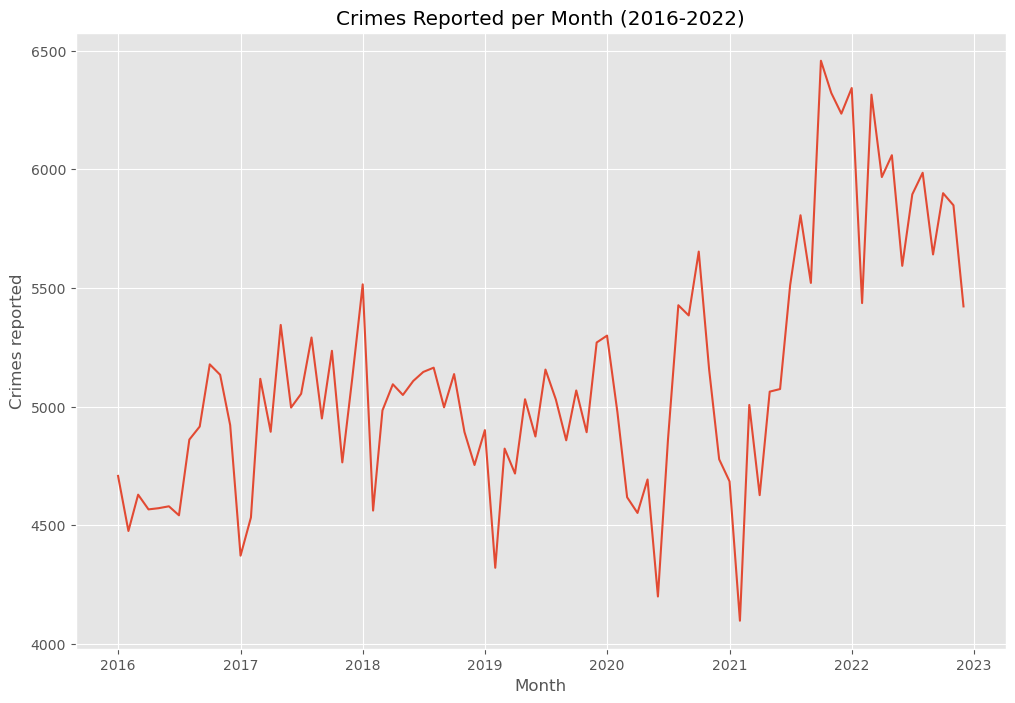

In [118]:
plt.plot(monthly_counts['OccurMonth'], monthly_counts['CrimeCount'])
plt.title('Crimes Reported per Month (2016-2022)')
plt.xlabel('Month')
plt.ylabel('Crimes reported')
plt.show()

In [11]:
# At this point I wanted to deal with the missing data and started working on finding the data from PPB that I was missing
# Found the data and worked out how to merge it in MergingData.ipynb
# Adding this data in here, rerunning the Kernal but skipping some previous lines until after the data has been merged
df_kaggle = pd.read_csv(CSV_KANGLE, sep='\t')
df_ppb = pd.read_csv(CSV_PPB)

In [21]:
df_kaggle = df_kaggle.rename(columns = {'Unnamed: 0': 'ID'})

In [15]:
# Converting relevant columns to datetime objects
for col in ['OccurDate', 'ReportDate']:
    df_ppb[col] = pd.to_datetime(df_ppb[col], errors='coerce').dt.strftime('%Y-%m-%d')
    df_kaggle[col] = pd.to_datetime(df_kaggle[col], errors='coerce').dt.strftime('%Y-%m-%d')

In [7]:
# Creating a dataframe to hold the missing data and convering it from a view to a frame
df_ppb_subset_missing = df_ppb[(df_ppb['ReportDate'] >= '2023-08-01') & (df_ppb['ReportDate'] <= '2023-12-31')]

In [23]:
# Creating the "ID" column and ensuring that there are no copies of the "ID" values
starting_id = df_kaggle['ID'].max() + 1
df_ppb_subset_missing = df_ppb_subset_missing.copy()  # Original variable is a view, making a hard copy here as a precaution
df_ppb_subset_missing['ID'] = range(starting_id, starting_id + len(df_ppb_subset_missing))  # Creating incrementing ID based on df_kaggle

In [25]:
# Creating the merged dataset
df = pd.concat([df_kaggle, df_ppb_subset_missing], ignore_index=True)  # Merging dfs, ignoring index

In [33]:
# Deleting dfs  no longer needed
del df_kaggle
del df_ppb
del df_ppb_subset_missing

In [35]:
# Running through the geopandas data conversion again
import geopandas as gpd
zip_gdf = gpd.read_file(f'{BASE_PATH_TO_FOLDER}data/supplemental/ZIP_Codes.shp')
crime_gdf = gpd.GeoDataFrame(
    df, # Providing pandas dataframe
    geometry=gpd.points_from_xy(df['OpenDataLon'], df['OpenDataLat']), # Providing data to convert to a geometrical point
    crs="EPSG:4326" # Setting corrdinate reference system that Tableau prefers
) # Creating a gdf for the crime data lon/lat
zip_gdf = zip_gdf.to_crs(crime_gdf.crs) # Converting the original shapefile data to match the new crime data gdf crs
crime_with_zip = gpd.sjoin(crime_gdf, zip_gdf[['ZIPCODE', 'geometry']], how='left', predicate='within')
zip_data = crime_with_zip[['ID', 'ZIPCODE']]  # isolating fields of interest for merge
df = df.merge(zip_data, on='ID', how='left') # Merging based on unique identifier and merging data farm zip_data onto df
del zip_data
del crime_with_zip
del zip_gdf
del crime_gdf

In [55]:
#Running through additional column creation again
df['ReportDate'] = pd.to_datetime(df['ReportDate'], errors='coerce')
df['OccurDate'] = pd.to_datetime(df['OccurDate'], errors='coerce')
# df['ReportDate'] = pd.to_datetime(df['ReportDate']).dt.date
# df['OccurDate'] = pd.to_datetime(df['OccurDate']).dt.date
df['OccurTime'] = pd.to_datetime(df['OccurTime'].astype(str).str.zfill(4), format='%H%M').dt.time
df['OccurDateTime'] = pd.to_datetime(df['OccurDate'].astype(str) + ' ' + df['OccurTime'].astype(str))
df['OccurHour'] = df['OccurDateTime'].dt.hour

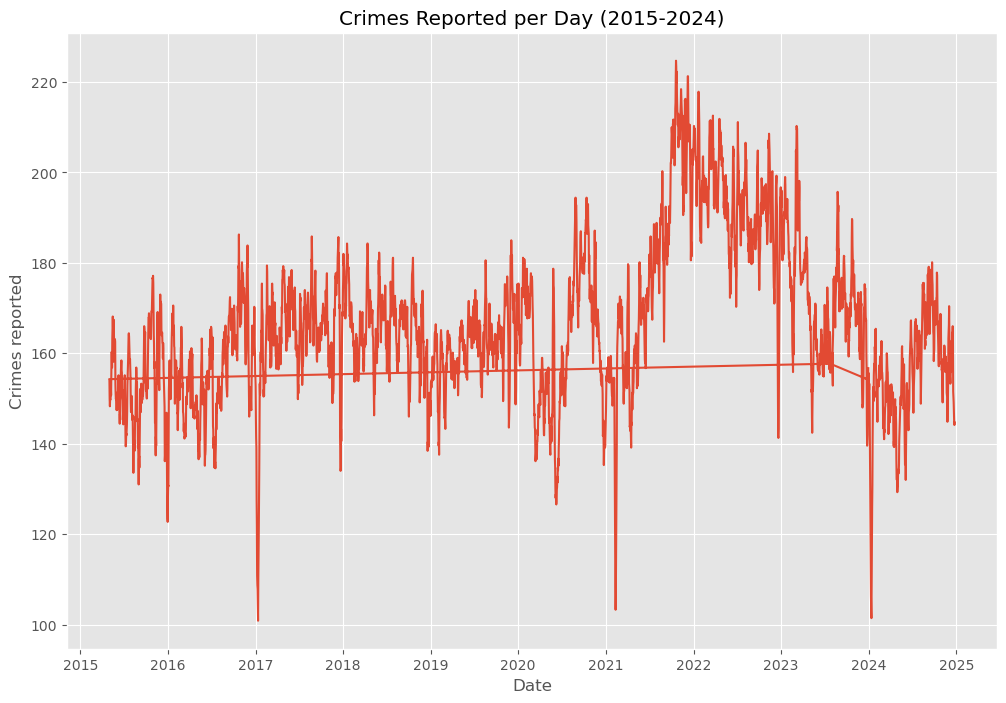

In [153]:
# A graph depictiong the total amounts of crime that were reported per day total
report_date_freqency = df['ReportDate'].value_counts(sort=False)
rolling_average = report_date_freqency.rolling(window=7).mean()
plt.plot(rolling_average.index, rolling_average.values)
plt.title('Crimes Reported per Day (2015-2024)')
plt.xlabel('Date')
plt.ylabel('Crimes reported')
plt.show()

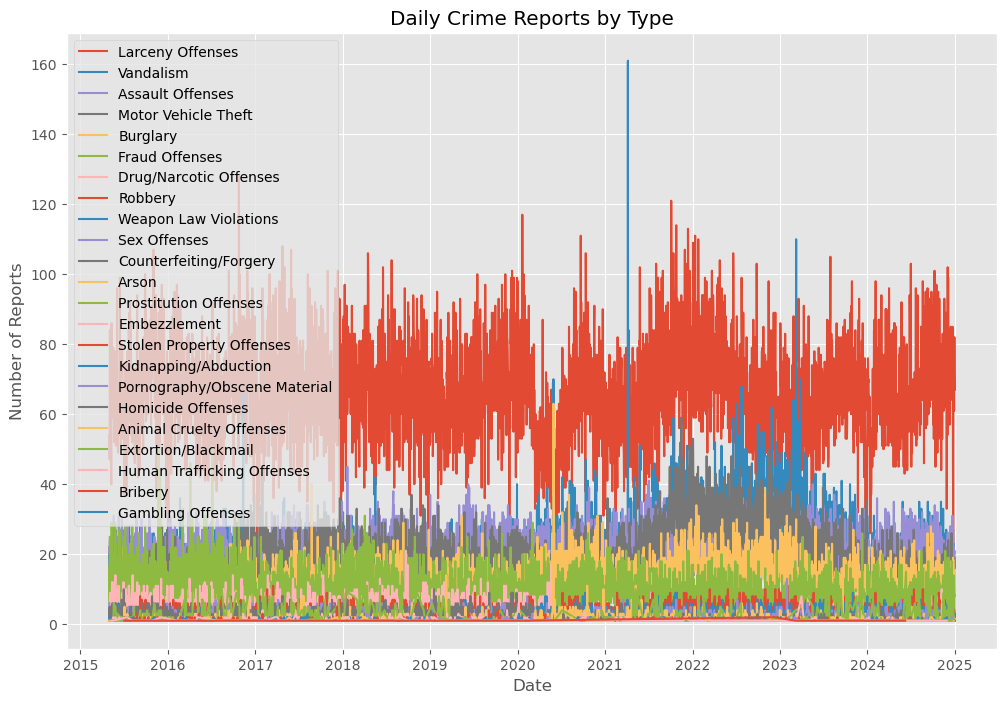

In [105]:
# A graph depictiong the breakdown of offence categories of occurred crimes per day (2015-2024)
# Note: Ignoring crimes which occurred prior to 2015
df['OccurDate'] = pd.to_datetime(df['OccurDate'], errors='coerce')
df_trimmed = df[(df['OccurDate'] >= '2015-01-01') & (df['OccurDate'] <= '2024-12-31')]
for offense in df_trimmed['OffenseCategory'].value_counts().index:
    # For each category of offense, plot the daily amount of occurances
    daily_counts = df_trimmed[df_trimmed['OffenseCategory'] == offense].groupby('OccurDate').size()
    plt.plot(daily_counts.index, daily_counts.values, label=offense)
plt.title("Daily Crime Occurrances by Offense Type")
plt.xlabel("Date")
plt.ylabel("Occurrances")
plt.legend()
plt.grid(True)
plt.show()

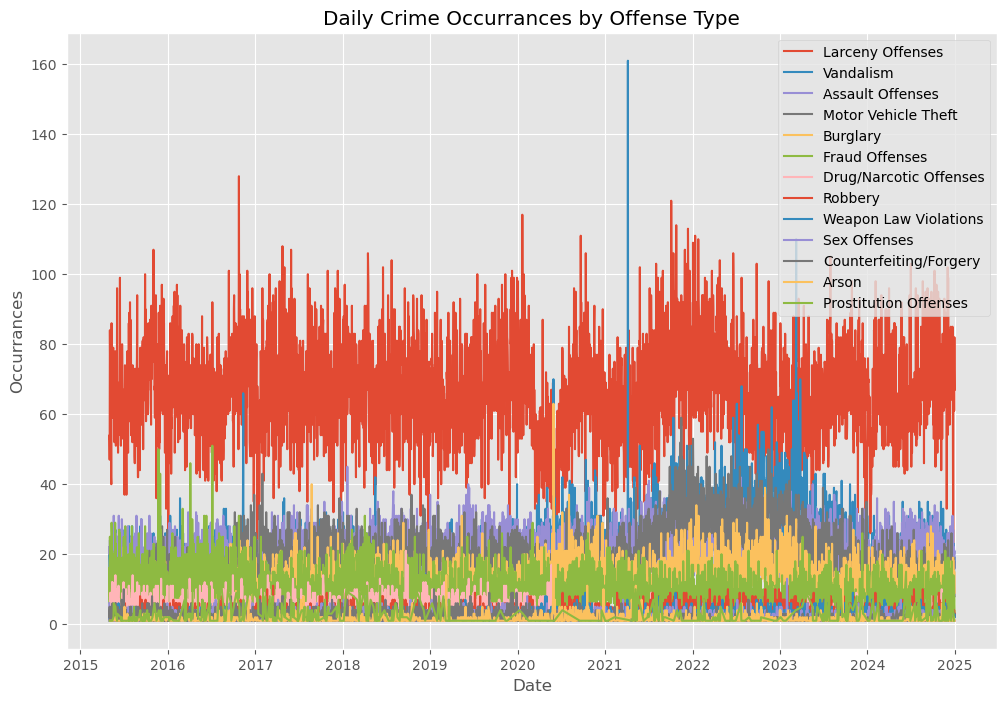

In [139]:
# A graph depictiong the breakdown of offence categories of occurred crimes per day where the total occurances > 1000 (2015-2024)
# Note: Ignoring crimes which occurred prior to 2015
df_trimmed = df[(df['OccurDate'] >= '2015-01-01') & (df['OccurDate'] <= '2024-12-31')]
# Take the offenses where total occurrances are greater than 1000 and return the names as a list
common_offenses = df_trimmed['OffenseCategory'].value_counts()[df_trimmed['OffenseCategory'].value_counts() > 1000].index.tolist()
for offense in common_offenses:
    # For each category of offense, plot the daily amount of occurances
    daily_counts = df_trimmed[df_trimmed['OffenseCategory'] == offense].groupby('OccurDate').size()
    plt.plot(daily_counts.index, daily_counts.values, label=offense)
plt.title("Daily Crime Occurrances by Most Common Offense Types")
plt.xlabel("Date")
plt.ylabel("Occurrances")
plt.legend()
plt.grid(True)
plt.show()

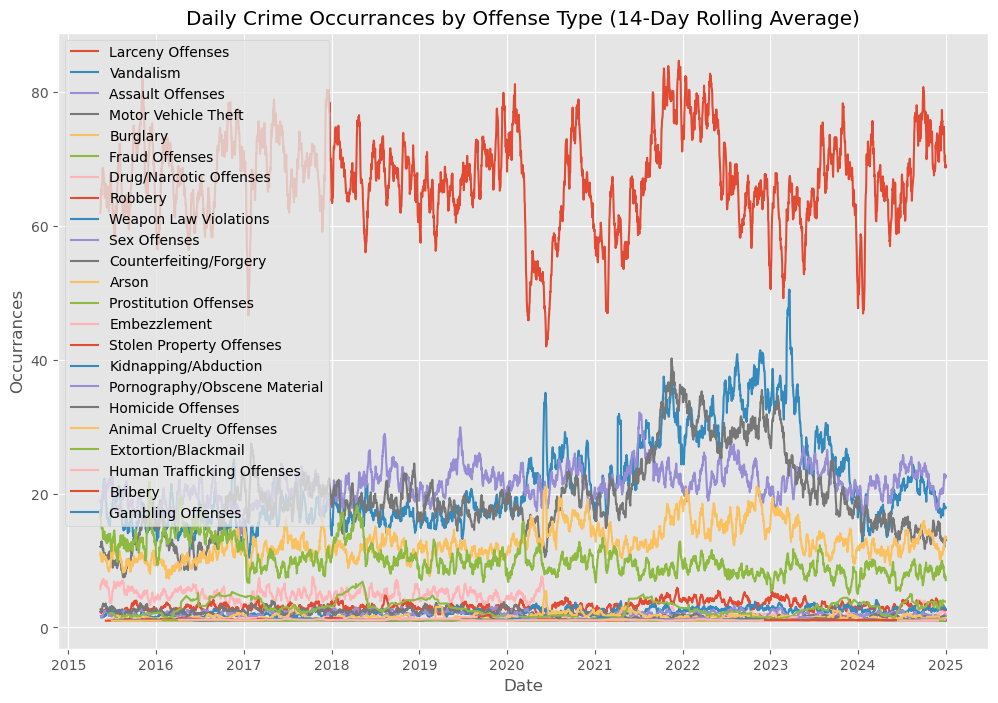

In [119]:
# A graph depictiong the breakdown of offence categories of occurred crimes per day using a 14-Day Rolling Average (2015-2024)
# Note: Ignoring crimes which occurred prior to 2015
df_trimmed = df[(df['OccurDate'] >= '2015-01-01') & (df['OccurDate'] <= '2024-12-31')]
for offense in df_trimmed['OffenseCategory'].value_counts().index:
    # For each category of offense, plot the daily amount of occurances and use a rolling average
    daily_counts = df_trimmed[df_trimmed['OffenseCategory'] == offense].groupby('OccurDate').size()
    rolling_average = daily_counts.rolling(window=14).mean()
    plt.plot(rolling_average.index, rolling_average.values, label=offense)
plt.title("Daily Crime Occurrances by Offense Type (14-Day Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Occurrances")
plt.legend()
plt.grid(True)
plt.show()

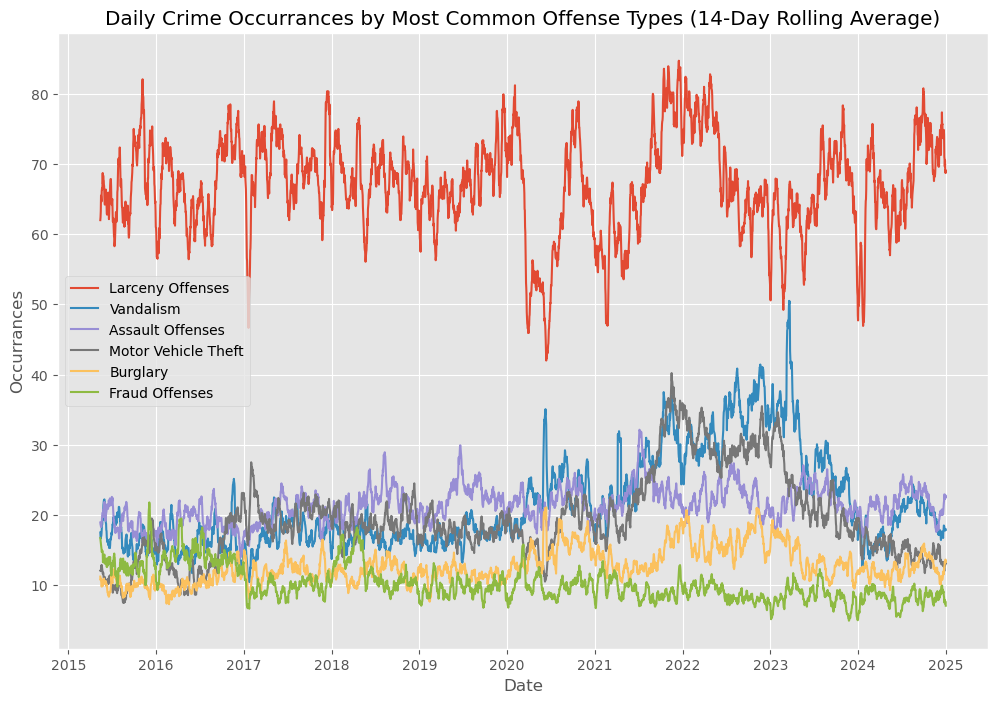

In [161]:
# A graph depictiong the breakdown of offence categories of occurred crimes per day where the total occurances > 1000 and a 14-Day Rolling Average (2015-2024)
# Note: Ignoring crimes which occurred prior to 2015
df_trimmed = df[(df['OccurDate'] >= '2015-01-01') & (df['OccurDate'] <= '2024-12-31')]
# Take the offenses where total occurrances are greater than 1000 and return the names as a list
common_offenses = df_trimmed['OffenseCategory'].value_counts()[df_trimmed['OffenseCategory'].value_counts() > 30000].index.tolist()
for offense in common_offenses:
    # For each category of offense, plot the daily amount of occurances
    daily_counts = df_trimmed[df_trimmed['OffenseCategory'] == offense].groupby('OccurDate').size()
    rolling_average = daily_counts.rolling(window=14).mean()
    plt.plot(rolling_average.index, rolling_average.values, label=offense)
plt.title("Daily Crime Occurrances by Most Common Offense Types (14-Day Rolling Average)")
plt.xlabel("Date")
plt.ylabel("Occurrances")
plt.legend()
plt.grid(True)
plt.show()

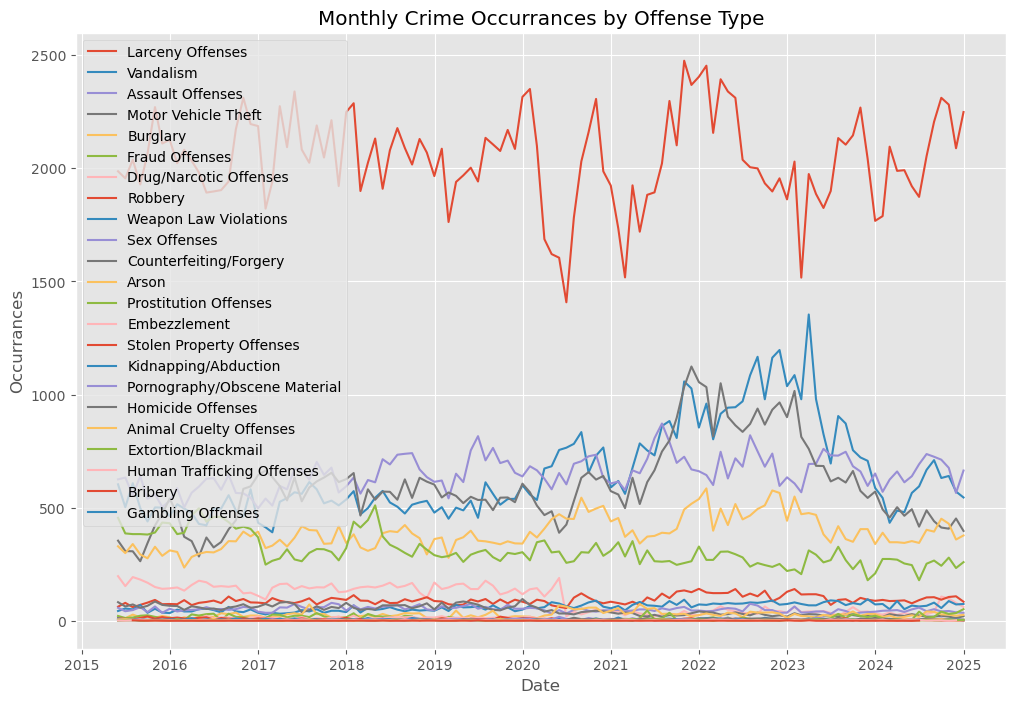

In [145]:
# A graph depictiong the breakdown of offence categories of occurred crimes per Month (2015-2024)
# Note: Ignoring crimes which occurred prior to 2015
df['OccurDate'] = pd.to_datetime(df['OccurDate'], errors='coerce')
df_trimmed = df[(df['OccurDate'] >= '2015-01-01') & (df['OccurDate'] <= '2024-12-31')]
for offense in df_trimmed['OffenseCategory'].value_counts().index:
    # For each category of offense, plot the Monthly amount of occurances
    daily_counts = df_trimmed[df_trimmed['OffenseCategory'] == offense].groupby(pd.Grouper(key='OccurDate', freq='ME')).size()
    plt.plot(daily_counts.index, daily_counts.values, label=offense)
plt.title("Monthly Crime Occurrances by Offense Type")
plt.xlabel("Date")
plt.ylabel("Occurrances")
plt.legend()
plt.grid(True)
plt.show()

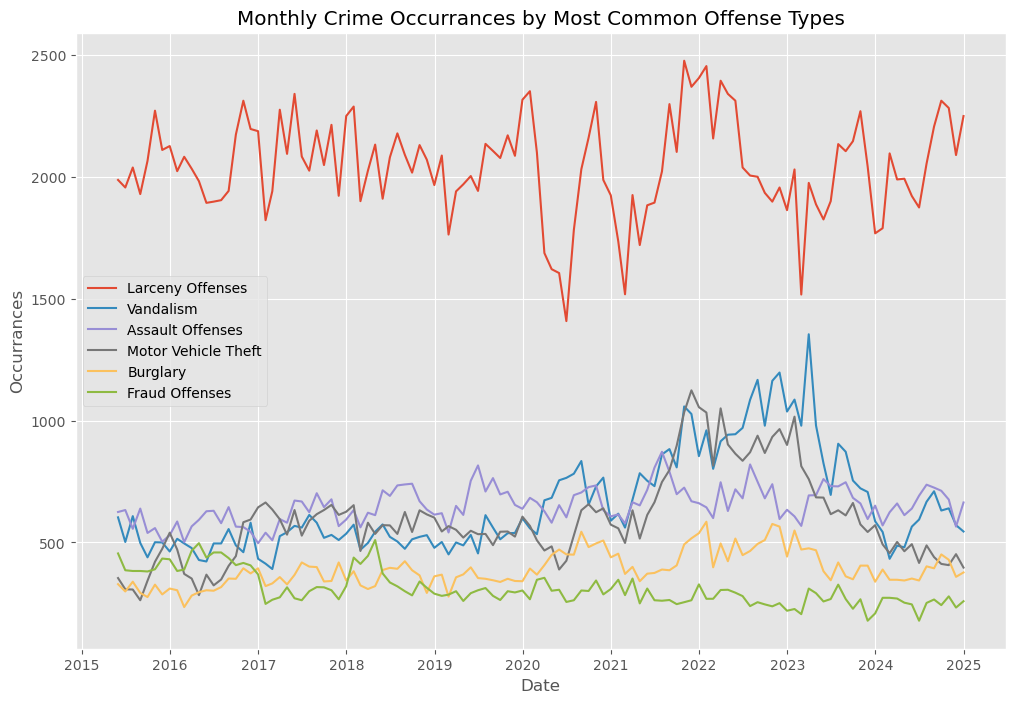

In [159]:
# A graph depictiong the breakdown of the most common offence categories of occurred crimes per Month (2015-2024)
# Note: Ignoring crimes which occurred prior to 2015
common_offenses = df_trimmed['OffenseCategory'].value_counts()[df_trimmed['OffenseCategory'].value_counts() > 30000].index
df_trimmed = df[(df['OccurDate'] >= '2015-01-01') & (df['OccurDate'] <= '2024-12-31')]
for offense in common_offenses:
    # For each category of offense, plot the Monthly amount of occurances
    daily_counts = df_trimmed[df_trimmed['OffenseCategory'] == offense].groupby(pd.Grouper(key='OccurDate', freq='ME')).size()
    plt.plot(daily_counts.index, daily_counts.values, label=offense)
plt.title("Monthly Crime Occurrances by Most Common Offense Types")
plt.xlabel("Date")
plt.ylabel("Occurrances")
plt.legend()
plt.grid(True)
plt.show()

In [137]:
plt.close()

In [147]:
df['OffenseCategory'].value_counts(sort=True)

OffenseCategory
Larceny Offenses                236807
Vandalism                        76178
Assault Offenses                 75578
Motor Vehicle Theft              69144
Burglary                         45184
Fraud Offenses                   35974
Drug/Narcotic Offenses           11218
Robbery                          10745
Weapon Law Violations             6996
Sex Offenses                      5857
Counterfeiting/Forgery            5295
Arson                             3155
Prostitution Offenses             1482
Embezzlement                       911
Stolen Property Offenses           754
Kidnapping/Abduction               664
Pornography/Obscene Material       559
Homicide Offenses                  489
Animal Cruelty Offenses            325
Extortion/Blackmail                293
Human Trafficking Offenses         237
Bribery                             18
Gambling Offenses                    1
Name: count, dtype: int64

In [149]:
pd.set_option('display.max_rows', 10)
df

,ID,Address,CaseNumber,CrimeAgainst,Neighborhood,OccurDate,OccurTime,OffenseCategory,OffenseType,OpenDataLat,OpenDataLon,OpenDataX,OpenDataY,ReportDate,OffenseCount,ZIPCODE,OccurDateTime,OccurHour
0,131141,700 BLOCK OF SW KING AVE,24-933461,Property,Goose Hollow,2024-12-31,08:35:00,Larceny Offenses,All Other Larceny,45.522619,-122.695457,7639475.0,684279.0,2024-12-31,1,97205,2024-12-31 08:35:00,8
1,144335,2500 BLOCK OF NE MARTIN LUTHER KING JR BLVD,24-333349,Property,Eliot,2024-12-31,18:15:00,Burglary,Burglary,45.540665,-122.661543,7648340.0,690622.0,2024-12-31,1,97212,2024-12-31 18:15:00,18
2,137002,1500 BLOCK OF N FLINT AVE,24-333656,Property,Lloyd,2024-12-31,19:00:00,Larceny Offenses,Theft of Motor Vehicle Parts or Accessories,45.534075,-122.668690,7646445.0,688269.0,2024-12-31,1,97227,2024-12-31 19:00:00,19
3,124540,NaN,24-X6019097,Person,Sumner,2024-12-31,17:40:00,Homicide Offenses,Murder and Non-negligent Manslaughter,NaN,NaN,NaN,NaN,2024-12-31,1,NaN,2024-12-31 17:40:00,17
4,130216,600 BLOCK OF SW PARK AVE,24-933457,Property,Downtown,2024-12-31,10:20:00,Larceny Offenses,Theft From Motor Vehicle,45.519952,-122.680464,7643290.0,683203.0,2024-12-31,1,97205,2024-12-31 10:20:00,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587859,587844,WB I84 FWY AT / NE 28TH AVE,23-288735,Society,Kerns,2023-11-05,02:03:00,Weapon Law Violations,Weapons Law Violations,45.530409,-122.637071,7654509.0,686717.0,2023-11-05,1,97232,2023-11-05 02:03:00,2
587860,587845,WB I84 FWY AT / NE 74TH AVE,23-269273,Person,Madison South,2023-10-14,00:53:00,Assault Offenses,Simple Assault,45.535703,-122.587109,7667358.0,688312.0,2023-10-14,1,97213,2023-10-14 00:53:00,0
587861,587846,WB I84 FWY EO / NE 53RD AVE,23-237188,Property,Rose City Park,2023-09-08,20:35:00,Vandalism,Vandalism,45.527393,-122.608116,7661898.0,685423.0,2023-09-08,1,97213,2023-09-08 20:35:00,20
587862,587847,WB SUNSET HWY AT / SYLVAN EXIT,23-225440,Society,Sylvan-Highlands,2023-08-27,14:20:00,Weapon Law Violations,Weapons Law Violations,45.508945,-122.731195,7630181.0,679546.0,2023-08-27,1,97221,2023-08-27 14:20:00,14


In [171]:
df.dtypes

ID                        int64
Address                  object
CaseNumber               object
CrimeAgainst             object
Neighborhood             object
                      ...      
ReportDate       datetime64[ns]
OffenseCount              int64
ZIPCODE                  object
OccurDateTime    datetime64[ns]
OccurHour                 int32
Length: 18, dtype: object

In [173]:
# Export the dataframe that I've been working with so far
df.to_csv(f"{BASE_PATH_TO_FOLDER}data/processed/Portland Crime Data with Zipcode Cleaned.csv", index=False)